# **Group Assignment**

Group 8 Members –

- 220343 Devansh Chaudhary
- 220435 Harshika Agrawal
- 220475 Jatin Madan
- 220505 Kartikeya Katiyar
- 220915 Rohit Raj


# **Recommendation System based on Matrix Factorization**


 Preprocessing and EDA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Importing files

In [ ]:
links=pd.read_csv('ml-32m/links.csv')
movies=pd.read_csv('ml-32m/movies.csv')
ratings=pd.read_csv('ml-32m/ratings.csv')
tags=pd.read_csv('ml-32m/tags.csv')

In [ ]:
print(links.shape)
print(movies.shape)
print(ratings.shape)
print(tags.shape)

(87585, 3)
(87585, 3)
(32000204, 4)
(2000072, 4)


In [ ]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


**Data Merging and Cleaning**

In [ ]:
# we have to merge all the four dataframes but their number of rows are different
# we will start with ratings, since it has the maximum number of rows
df = movies.merge(ratings, on='movieId', how='left')

In [ ]:
df

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,2.5,1.169265e+09
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,3.0,8.500851e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.0,1.027306e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19.0,3.0,9.747045e+08
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,20.0,5.0,1.553184e+09
...,...,...,...,...,...,...
32003352,292731,The Monroy Affaire (2022),Drama,50685.0,4.0,1.697075e+09
32003353,292737,Shelter in Solitude (2023),Comedy|Drama,165364.0,1.5,1.697146e+09
32003354,292753,Orca (2023),Drama,150812.0,4.0,1.697141e+09
32003355,292755,The Angry Breed (1968),Drama,91097.0,1.0,1.697145e+09


In [ ]:
df.isnull().sum()

movieId         0
title           0
genres          0
userId       3153
rating       3153
timestamp    3153
dtype: int64

The ~3,153 null values represent movies that are in our movies list but have never been rated by
any user in the ratings dataset. Since our analysis is focused on rating behavior, we can safely
drop these rows.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32003357 entries, 0 to 32003356
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   movieId    int64  
 1   title      object 
 2   genres     object 
 3   userId     float64
 4   rating     float64
 5   timestamp  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.4+ GB


# **Feature Engineering**
 The genres column is a single string with values separated by a pipe (|). This format is difficult to
query. We will transform it by "one-hot encoding" each genre into its own column. A 1 will
indicate the movie belongs to that genre, and a 0 will indicate it does not.

In [ ]:
# Separate genres since they are separated by '|' and create dummy columns for each genre, if they are present in the movie - 1 else - 0
df['genres'] = df['genres'].str.split('|')
all_genres = set()
for genres in df['genres']:
    all_genres.update(genres)
for genre in all_genres:
    df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
df.drop('genres', axis=1, inplace=True)


In [ ]:
df

,movieId,title,userId,rating,timestamp,Musical,Western,Thriller,Sci-Fi,(no genres listed),...,Film-Noir,War,Mystery,Fantasy,Drama,Documentary,Animation,Comedy,Romance,Horror
0,1,Toy Story (1995),10.0,2.5,1.169265e+09,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
1,1,Toy Story (1995),11.0,3.0,8.500851e+08,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,1,Toy Story (1995),17.0,4.0,1.027306e+09,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
3,1,Toy Story (1995),19.0,3.0,9.747045e+08,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
4,1,Toy Story (1995),20.0,5.0,1.553184e+09,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32003352,292731,The Monroy Affaire (2022),50685.0,4.0,1.697075e+09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
32003353,292737,Shelter in Solitude (2023),165364.0,1.5,1.697146e+09,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
32003354,292753,Orca (2023),150812.0,4.0,1.697141e+09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
32003355,292755,The Angry Breed (1968),91097.0,1.0,1.697145e+09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


 One of the "genres" is (no genres listed). This is an awkward column name, so let's rename it to
Unknown.

In [ ]:
# change '(no genres listed)' to 'Unknown' in the genres column
df['Unknown'] = df['(no genres listed)']
df.drop('(no genres listed)', axis=1, inplace=True)
df.head()

,movieId,title,userId,rating,timestamp,Musical,Western,Thriller,Sci-Fi,Adventure,...,War,Mystery,Fantasy,Drama,Documentary,Animation,Comedy,Romance,Horror,Unknown
0,1,Toy Story (1995),10.0,2.5,1.169265e+09,0,0,0,0,1,...,0,0,1,0,0,1,1,0,0,0
1,1,Toy Story (1995),11.0,3.0,8.500851e+08,0,0,0,0,1,...,0,0,1,0,0,1,1,0,0,0
2,1,Toy Story (1995),17.0,4.0,1.027306e+09,0,0,0,0,1,...,0,0,1,0,0,1,1,0,0,0
3,1,Toy Story (1995),19.0,3.0,9.747045e+08,0,0,0,0,1,...,0,0,1,0,0,1,1,0,0,0
4,1,Toy Story (1995),20.0,5.0,1.553184e+09,0,0,0,0,1,...,0,0,1,0,0,1,1,0,0,0


In [ ]:
df.isnull().sum()

movieId           0
title             0
userId         3153
rating         3153
timestamp      3153
Musical           0
Western           0
Thriller          0
Sci-Fi            0
Adventure         0
Crime             0
Children          0
IMAX              0
Action            0
Film-Noir         0
War               0
Mystery           0
Fantasy           0
Drama             0
Documentary       0
Animation         0
Comedy            0
Romance           0
Horror            0
Unknown           0
dtype: int64

In [ ]:
# remove rows with missing values
df.dropna(inplace=True)
df.isnull().sum()

movieId        0
title          0
userId         0
rating         0
timestamp      0
Musical        0
Western        0
Thriller       0
Sci-Fi         0
Adventure      0
Crime          0
Children       0
IMAX           0
Action         0
Film-Noir      0
War            0
Mystery        0
Fantasy        0
Drama          0
Documentary    0
Animation      0
Comedy         0
Romance        0
Horror         0
Unknown        0
dtype: int64

# Processing Timestamps
 The timestamp column is in Unix format (seconds since 1970). We'll convert this to a more
human-readable datetime object, which will allow us to extract features like the year.

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
# add convenient columns for analysis
df['rating_year'] = df['timestamp'].dt.year

In [ ]:
if df['rating_year'].isnull().any():
    df['rating_year'] = df['rating_year'].astype('Int64')
else:
    df['rating_year'] = df['rating_year'].astype(int)
# quick sanity print
print('rating_year dtype:', df['rating_year'].dtype)
# show counts including NA
display(df['rating_year'].value_counts(dropna=False).head())

rating_year dtype: int64


rating_year
2016    1918739
2000    1912322
2017    1827953
2005    1752573
2015    1743866
Name: count, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32000204 entries, 0 to 32003356
Data columns (total 26 columns):
 #   Column       Dtype         
---  ------       -----         
 0   movieId      int64         
 1   title        object        
 2   userId       float64       
 3   rating       float64       
 4   timestamp    datetime64[ns]
 5   Musical      int64         
 6   Western      int64         
 7   Thriller     int64         
 8   Sci-Fi       int64         
 9   Adventure    int64         
 10  Crime        int64         
 11  Children     int64         
 12  IMAX         int64         
 13  Action       int64         
 14  Film-Noir    int64         
 15  War          int64         
 16  Mystery      int64         
 17  Fantasy      int64         
 18  Drama        int64         
 19  Documentary  int64         
 20  Animation    int64         
 21  Comedy       int64         
 22  Romance      int64         
 23  Horror       int64         
 24  Unknown      int64         

# **Exploratory Data Analysis (EDA)**

**Distribution of All Movie Ratings**

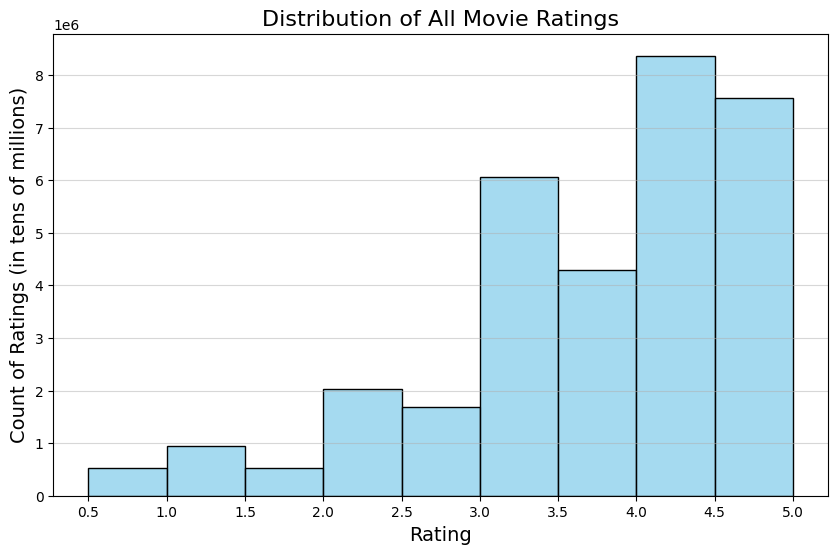

In [ ]:
plt.figure(figsize=(10, 6))
# Using histplot for continuous data like ratings, with explicit bins for each half-point rating
sns.histplot(df['rating'], bins=np.arange(0.5, 5.5, 0.5), kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of All Movie Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=14)
plt.ylabel('Count of Ratings (in tens of millions)', fontsize=14)
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.grid(axis='y', alpha=0.5)
plt.show()






**Observations:**


*   Ratings are Skewed Toward Higher Values: Most ratings given by users are concentrated at the higher end (4.0–5.0). The tallest bars are for ratings around 4 and 4.5.
*   Few Low Ratings: Ratings below 2 are much less frequent, indicating that users tend not to rate movies poorly often.
*   Peak at 4.0 and 4.5: There is a noticeable peak at around 4.0 and 4.5, suggesting users frequently rate movies positively.
*   Moderate Ratings (3.0–3.5): There is a
moderate count for middle ratings, showing that some users do take a neutral position.



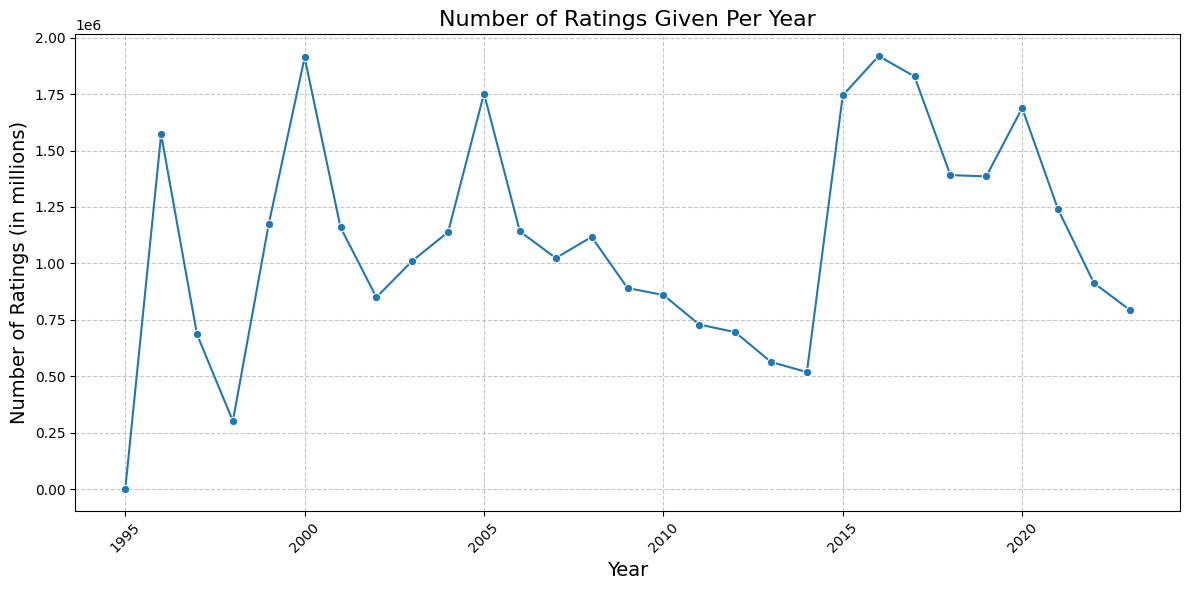

In [ ]:
ratings_per_year = df['rating_year'].value_counts().sort_index().reset_index()
ratings_per_year.columns = ['Year', 'Count']

plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Count', data=ratings_per_year, marker='o')
plt.title('Number of Ratings Given Per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Ratings (in millions)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Observations:**

*   First Ratings Around 1995: Activity appears to begin around 1995, with a sharp initial increase.
*  Ratings Fluctuate Over Time: The number of ratings given each year varies significantly, with multiple peaks and drops.


*   Major Peaks: There are prominent peaks around 2000, 2005, and especially 2015–2018, where yearly ratings approach or exceed 1.8 million.
*   Declines Between Peaks: Periods of decline follow each major peak, suggesting variable user engagement or potential platform changes.




*   Recent Trends: Post-2017, ratings remain relatively high but show a downward trend in the last few years.












# Rating Distribution by Genre

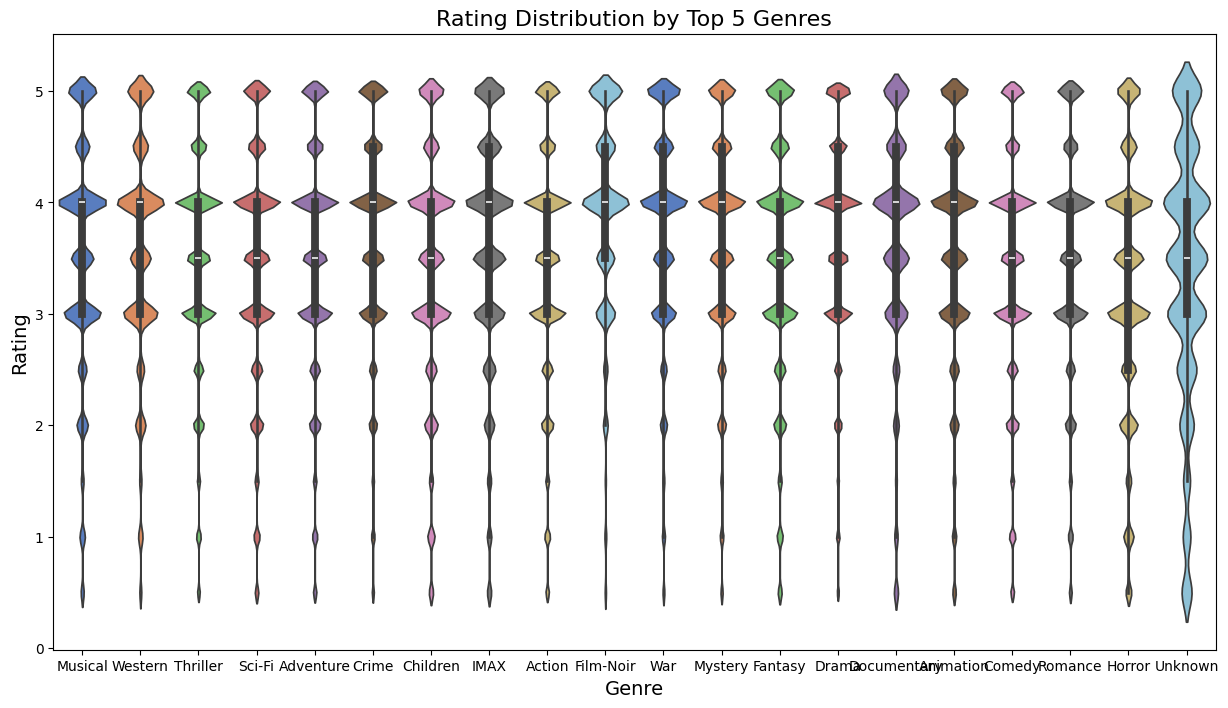

In [ ]:
# First, find the top 5 genres
top_genres = df[genre_columns].sum().index.tolist()

# We need to "melt" the dataframe from wide (one-hot) to long format for this plot
# This can be slow on 32M rows, so let's sample or be patient
# A more efficient way is to create a long-form dataframe
df_long_genre = df.melt(id_vars=['rating'],
                        value_vars=top_genres,
                        var_name='genre',
                        value_name='is_genre')

# Filter for rows where the movie *is* that genre (is_genre == 1)
df_genre_ratings = df_long_genre[df_long_genre['is_genre'] == 1]

plt.figure(figsize=(15, 8))
sns.violinplot(x='genre', y='rating', data=df_genre_ratings, palette='muted')
plt.title('Rating Distribution by Top 5 Genres', fontsize=16)
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.show()

**Observations:**
  

*   The rating distributions are remarkably similar across almost all genres.
*   The median rating (the white dot) for most genres is 4.0.


*   This suggests that while what people watch varies (e.g., more Drama than Western),
how they rate (generally positively) is consistent.







# Top 10 Most Reviewed Movies

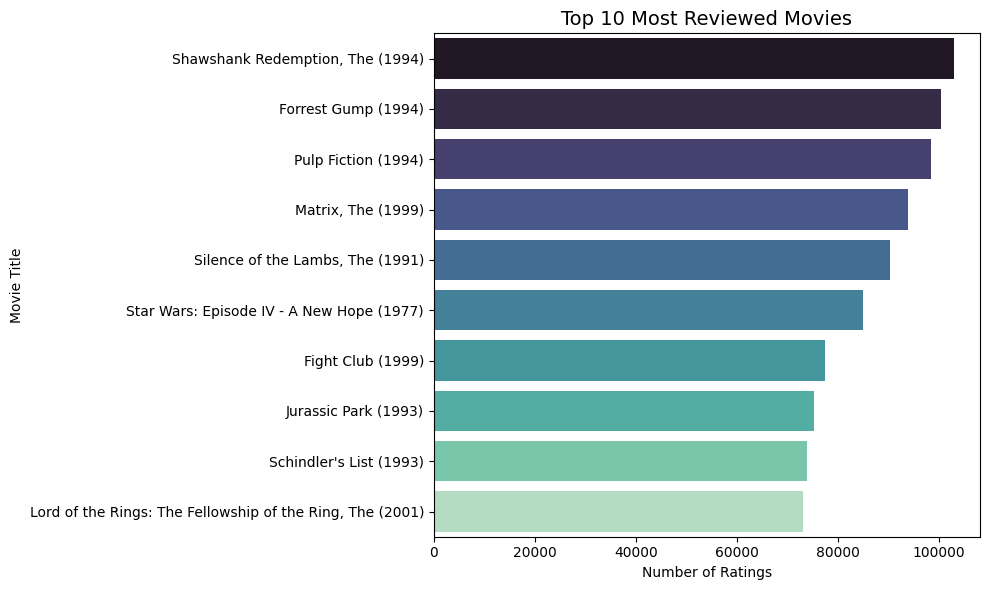

In [ ]:
# Merge both datasets on movieId
merged = pd.merge(ratings, movies, on='movieId')
# Count number of ratings per movie
movie_counts = merged.groupby('title').size().reset_index(name='num_ratings')

# Sort to get top 10 most reviewed movies
top_movies = movie_counts.sort_values(by='num_ratings', ascending=False).head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(y='title', x='num_ratings', data=top_movies, palette='mako')
plt.title("Top 10 Most Reviewed Movies", fontsize=14)
plt.xlabel("Number of Ratings")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()

**Observations:**


*    Top Movie: "Shawshank Redemption, The (1994)" is the most reviewed movie in this dataset, with just over 100,000 ratings.
*   Top 3: The top three are "Shawshank Redemption, The (1994)", "Forrest Gump
(1994)", and "Pulp Fiction (1994)". All were released in 1994.

*   Ranking: The movies are sorted from most reviewed (at the top) to least reviewed
(at the bottom of this top 10 list).
*   10th Place: The 10th most reviewed movie on this list is "Lord of the Rings: The
Fellowship of the Ring, The (2001)", with roughly 75,000 ratings.


# Number of Movies per Genre

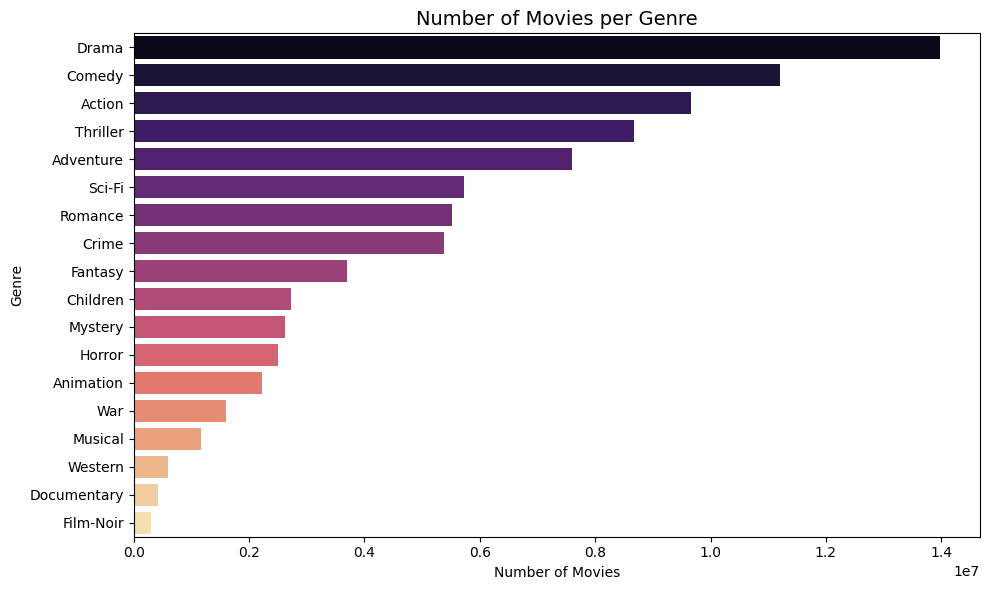

In [ ]:
# Select only genre columns — adjust the list if your dataset has different columns
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
              'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
              'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Sum up how many movies belong to each genre
genre_counts = df[genre_cols].sum().sort_values(ascending=False)

# Convert to DataFrame for plotting
genre_counts_df = genre_counts.reset_index()
genre_counts_df.columns = ['Genre', 'Number_of_Movies']

# Plot
plt.figure(figsize=(10,6))
sns.barplot(y='Genre', x='Number_of_Movies', data=genre_counts_df, palette='magma')
plt.title("Number of Movies per Genre", fontsize=14)
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

**Observations:**

*   Top Genre: "Drama" has the most number of movies by a wide margin.
*   Top 3: "Comedy" has the second most number of movies, followed by "Action".

*   Genres like "Film-Noir", "Documentary", and "Western" have the least number of
movies.


# Average Movie Rating per Year

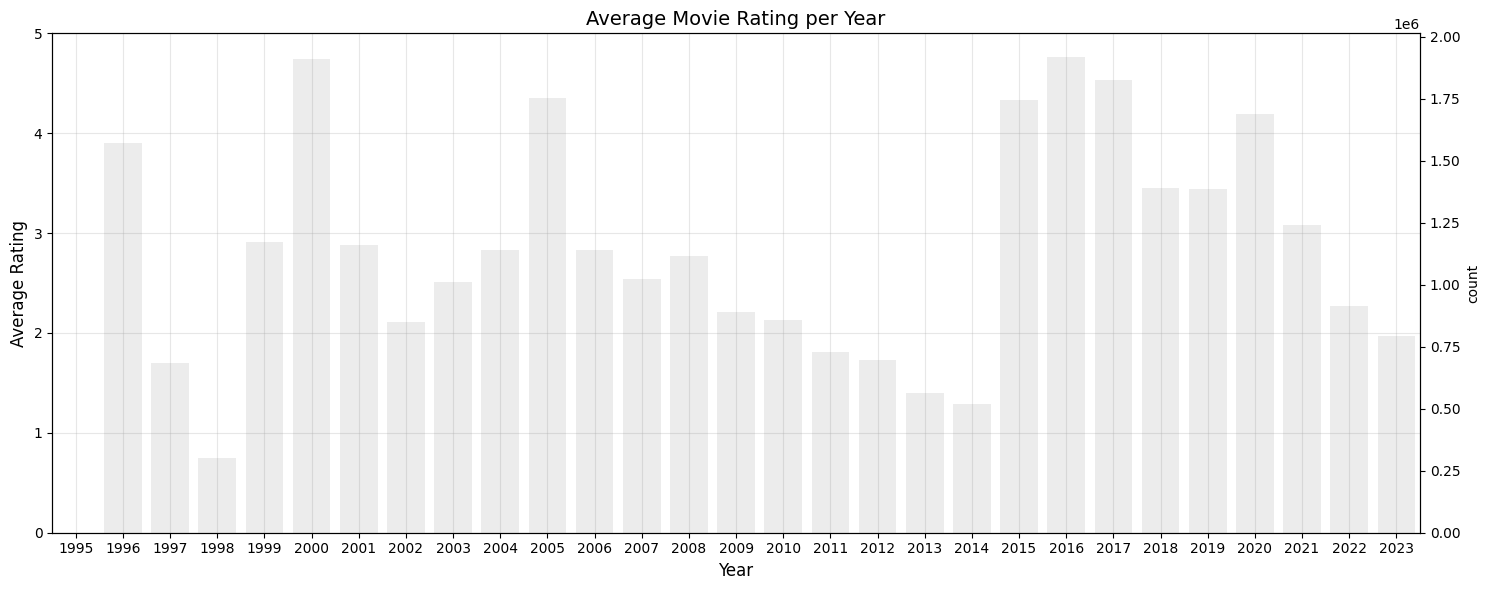

In [ ]:
# ===== Average rating trend over year =====
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure df exists in the notebook and has 'rating' and 'rating_year'
# Aggregate: mean rating and count per year
rating_year_stats = df.groupby('rating_year')['rating'].agg(['mean', 'count']).reset_index().sort_values('rating_year')

plt.figure(figsize=(15,6))
sns.lineplot(data=rating_year_stats, x='rating_year', y='mean', marker='o')
plt.title('Average Movie Rating per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.ylim(0, 5)
plt.grid(alpha=0.3)

# Add bar plot for counts on a secondary axis
ax1 = plt.gca()
ax2 = ax1.twinx()
sns.barplot(data=rating_year_stats, x='rating_year', y='count', alpha=0.15, ax=ax2, color='gray')
# ax2.set_ylabel('Number of Ratings', fontsize=12)

# Improve x ticks
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observations:**

*   Early Years (1995–2000): There is high fluctuation and some extremely high average ratings—likely due to fewer ratings or initial dataset characteristics.
*   Stabilization (2001–2013): Average ratings settle mostly between 2.0 and 3.0, indicating more consistent and balanced user feedback.

*   Recent Peak (2014–2018): Average ratings rise prominently, reaching above 4.0 in some years. This aligns with increased platform activity and rating counts.
*   Recent Years (2019–2023): The average falls back toward the 3.0–4.0 range, showing a decline in average positivity.












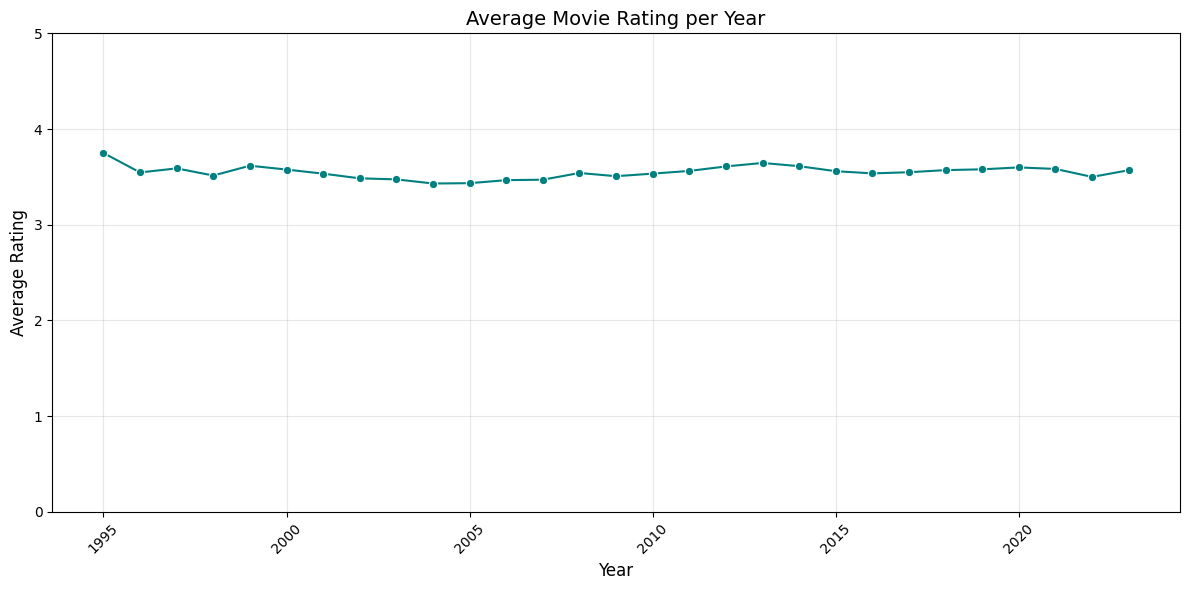

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute yearly mean rating
rating_year_stats = df.groupby('rating_year')['rating'].mean().reset_index().sort_values('rating_year')

plt.figure(figsize=(12,6))
sns.lineplot(data=rating_year_stats, x='rating_year', y='rating', marker='o', color='teal')
plt.title('Average Movie Rating per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.ylim(0, 5)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Observations:**

*   Consistent Average Ratings: The average rating
per year remains quite stable over the entire period, fluctuating narrowly between approximately 3.4 and 3.8.
*   No Drastic Swings: Unlike some bar plots that showed high peaks and drops (possibly due to low data or counting both axes), this line plot suggests a largely consistent rating culture among users.


*   Slight Dip and Rise: There are minor downward and upward trends, but no abrupt changes across the years.











### Genre Co-occurrence Correlation Analysis

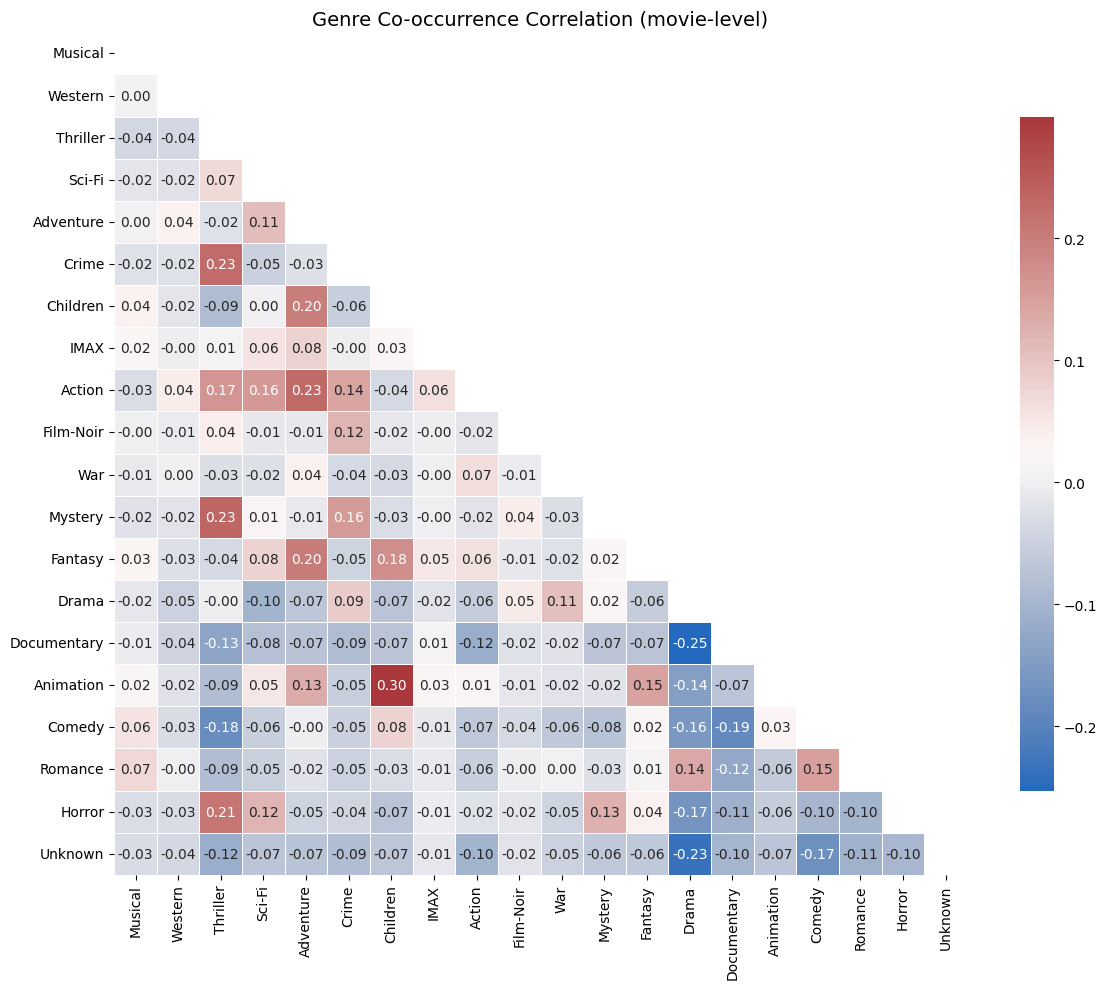

In [ ]:
# ===== Correlation between genres (co-occurrence) =====

# Detect genre columns automatically (adjust if needed)
non_genre_cols = {'movieId', 'title', 'userId', 'rating', 'timestamp', 'rating_year'}
genre_cols = [c for c in df.columns if c not in non_genre_cols]

# Build movie-level presence matrix: 1 if movie has genre, 0 otherwise
# Use groupby(movieId) and take max (if any rating row shows that movie has genre -> movie has genre)
movies_genres = df.groupby('movieId')[genre_cols].max()

# Compute correlation matrix (Pearson on binary columns)
corr = movies_genres.corr()

# Heatmap (mask upper triangle for readability)
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12,10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='vlag', linewidths=.5, cbar_kws={'shrink':.8})
plt.title('Genre Co-occurrence Correlation (movie-level)', fontsize=14)
plt.tight_layout()
plt.show()


**Observations:**


*   Positive correlations: Crime & Thriller (0.23), Children & Animation (0.30), Comedy & Romance (0.15) are common genre combinations.
*   Negative correlation: Drama & Documentary (-0.25) rarely overlap.

*   Most genres: Show weak or near-zero correlation, meaning genre mixing is limited, but a few pairs are notably likely or unlikely to co-occur.
*   Implication: Use positive pairs for multi-genre recommendations and recognize negative pairs as mutually exclusive types.












### Genre Popularity and Share Over Time (Top 8 Genres)

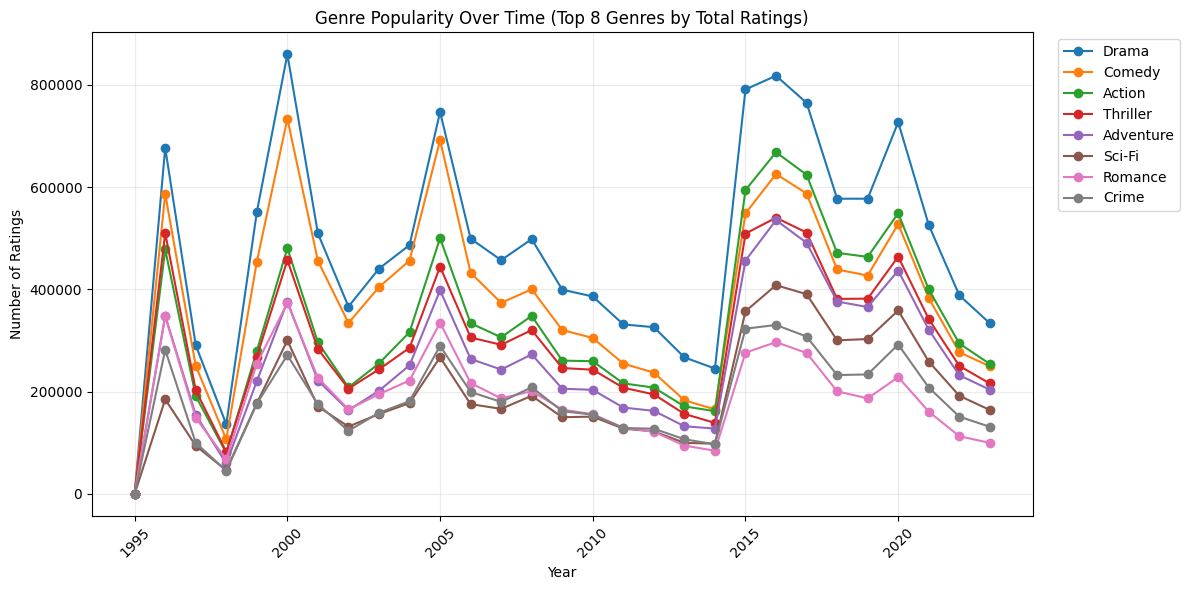

<Figure size 1200x600 with 0 Axes>

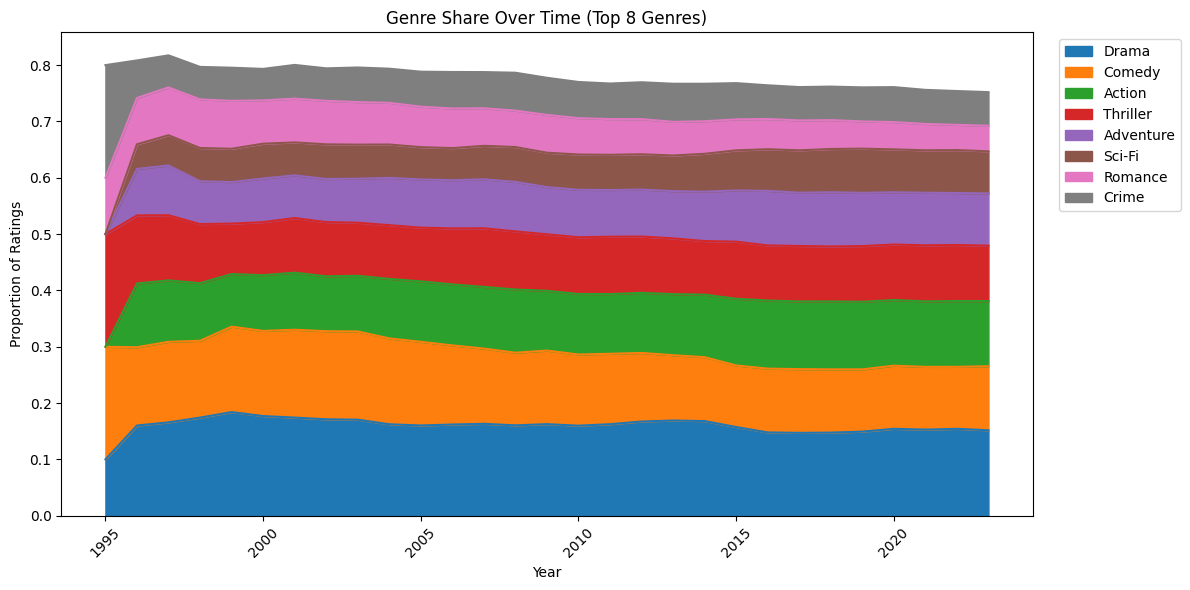

In [ ]:
# ===== Genre popularity over time =====

# Reuse genre_cols computed earlier
# Aggregate ratings per year per genre by summing the one-hot flags (each rating row contributes 1 to the genre(s))
genre_year_counts = df.groupby('rating_year')[genre_cols].sum().sort_index()

# Choose top N genres by overall counts
TOP_N = 8
total_by_genre = genre_year_counts.sum().sort_values(ascending=False)
top_genres = total_by_genre.head(TOP_N).index.tolist()

# Line plot for top genres
plt.figure(figsize=(12,6))
for g in top_genres:
    plt.plot(genre_year_counts.index, genre_year_counts[g], marker='o', label=g)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
plt.xlabel('Year')
plt.ylabel('Number of Ratings')
plt.title(f'Genre Popularity Over Time (Top {TOP_N} Genres by Total Ratings)')
plt.xticks(rotation=45)
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()

# ---- Optional: stacked area plot of relative share (proportions) ----
genre_year_prop = genre_year_counts.div(genre_year_counts.sum(axis=1), axis=0)  # proportion per year

plt.figure(figsize=(12,6))
genre_year_prop[top_genres].plot.area(figsize=(12,6), stacked=True)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
plt.xlabel('Year')
plt.ylabel('Proportion of Ratings')
plt.title(f'Genre Share Over Time (Top {TOP_N} Genres)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Observations:**


*   Drama and Comedy consistently lead in total ratings every year, followed by Action and Thriller.
*   All genres show matching peaks and troughs in popularity, reflecting overall user activity patterns.

*   Despite absolute count changes, the proportion of ratings for each genre stays stable over time—Drama, Comedy, and Action always make up the largest shares.
*   No genre shows a sharp rise or fall in its relative share, indicating enduring audience preferences for these top genres across decades.









Saving the Final Pre-processed Dataset

In [ ]:
 # Replace 'movies_df' with your actual dataframe name
 df.to_csv("cleaned_movies.csv", index=False)